In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
tables = inspector.get_table_names()
columns = inspector.get_columns(tables[0])
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns(tables[1])
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

Text(0.5,1,'Last 12 Month Preciptation Data')

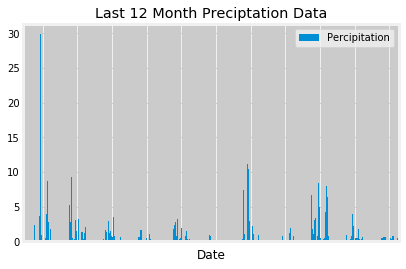

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Vacation Date is July 8-15 2017
#from dateutil.relativedelta import relativedelta
# Calculate the date 1 year ago from today
vacay_date = dt.date(2017, 7 ,8)
date_last_year = vacay_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
past_year_data = session.query(Measurement.date, func.sum(Measurement.prcp)).\
                 filter(Measurement.date > date_last_year, Measurement.date <= vacay_date).group_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
percip_df = pd.DataFrame(past_year_data, columns=['Date', 'Percipitation']).set_index('Date')
# Sort the dataframe by date
percip_df = percip_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
ax = percip_df.plot(kind='bar', rot=45)
# Rotate the xticks for the dates
# Get rid of x_ticks
ax.set_xticklabels([])
plt.title("Last 12 Month Preciptation Data")

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percip_df.describe()

,Percipitation
count,365.000000
mean,1.165918
std,2.388855
min,0.000000
25%,0.060000
50%,0.430000
75%,1.250000
max,29.850000


In [15]:
# How many stations are available in this dataset? 9
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = most_active[0][0]
#most_active_station
most_active_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                   filter(Measurement.station == most_active_station).all()
most_active_data

[(54.0, 85.0, 71.66378066378067)]

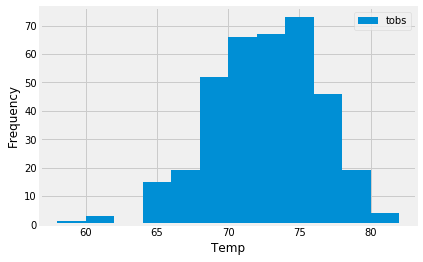

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twelve_months_data = session.query(Measurement.tobs).group_by(Measurement.date). \
                     order_by(Measurement.date.desc()).limit(365).all()
bin_data = [data[0] for data in last_twelve_months_data]
bin_data
plt.hist(bin_data, bins=12, label="tobs")
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.legend(loc='best')

In [19]:

# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    #initialize and start engine for query
    engine = create_engine("sqlite:///Resources/hawaii.sqlite")
    session = Session(engine)
    Base = automap_base()
    # reflect the tables
    Base.prepare(engine, reflect=True)
    Measurement = Base.classes.measurement
    
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.4375, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-07-08', '2017-07-10')
trip_temps

[(69.0, 78.53846153846153, 82.0)]

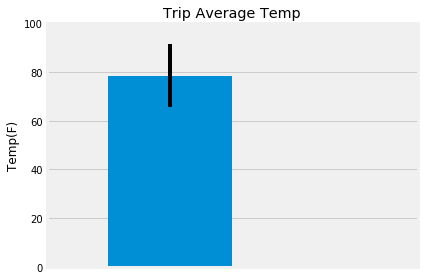

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tempyerr = (trip_temps[0][2]-trip_temps[0][0])
plt.bar([0], trip_temps[0][1], yerr=tempyerr, width=.5)
plt.ylabel("Temp(F)")
plt.xlim(-.5,1)
plt.ylim(0, 100)
plt.xticks([])
plt.title("Trip Average Temp")
plt.tight_layout()

In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
rainfall_data = session.query(*sel).filter(Measurement.station == Station.station).\
                filter(Measurement.date >= "2017-07-08", Measurement.date <= "2017-07-10").group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_data

[('USC00519281',
  0.13,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 0.11, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  0.06,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  0.04,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    #initialize and start engine for query
    engine = create_engine("sqlite:///Resources/hawaii.sqlite")
    session = Session(engine)
    Base = automap_base()
    # reflect the tables
    Base.prepare(engine, reflect=True)
    Measurement = Base.classes.measurement
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = dt.date(2017, 7 ,8)
numdays = 7
# Use the start and end date to create a range of dates
vacay_range = []
for x in range (0, numdays):
    vacay_range.append(start_date + dt.timedelta(days = x))
#vacay_range
# Stip off the year and save a list of %m-%d strings
vacay_day_month_range = []
for day in vacay_range:
    vacay_day_month_range.append(day.strftime('%m-%d'))
vacay_day_month_range
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in vacay_day_month_range:
    normals.append(daily_normals(day))
normals[0]
vacay_day_month_range

['07-08', '07-09', '07-10', '07-11', '07-12', '07-13', '07-14']

In [40]:
normals_dict = []
for normal in normals:
    temp = {}
    temp['tmin'] = normal[0][0]
    temp['tavg'] = normal[0][1]
    temp['tmax'] = normal[0][2]
    normals_dict.append(temp)

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacay_normals_df = pd.DataFrame(normals_dict, index=vacay_range)
vacay_normals_df

,tavg,tmax,tmin
2017-07-08,76.083333,83.0,69.0
2017-07-09,76.192982,83.0,68.0
2017-07-10,75.620690,82.0,68.0
2017-07-11,75.789474,81.0,70.0
2017-07-12,75.964912,82.0,67.0
2017-07-13,76.189655,81.0,69.0
2017-07-14,76.228070,82.0,61.0


Text(0.5,1,'Trip Daily Normals')

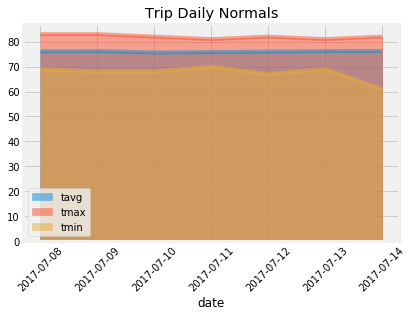

In [41]:
my_xticks = []
for day in vacay_range:
    my_xticks.append(day.strftime('%Y-%m-%d'))
my_xticks
# Plot the daily normals as an area plot with `stacked=False`
vacay_normals_df.plot(kind='area', stacked=False, rot=45)
plt.xlabel("date")
plt.title("Trip Daily Normals")